In [1]:
!pip install tensorflow==2.15.0
!pip install tensorflow_addons
!pip install bruges
!pip install gdown

In [9]:
# Import libraries
import itertools
import os
import time
from tqdm import tqdm



import gdown
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import grid_to_graph
from skimage import exposure, filters
from skimage.restoration import unwrap_phase
from skimage.transform import resize

import bruges
from scipy import ndimage

# Function to download and load numpy arrays
def download_file(file_id, local_filename):
    """
    Downloads a file from Google Drive using gdown and loads it using numpy.

    Parameters:
    file_id (str): The Google Drive file ID.
    local_filename (str): The local path where the file will be saved.

    Returns:
    np.ndarray: The loaded numpy array.
    """
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, local_filename, quiet=False)
    return local_filename


def seed_everything(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_everything()

In [4]:
#check if GPU available

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

tf.config.experimental.set_memory_growth(
    gpus[0], True
)

In [29]:
def custom_dataset_5d_strided_crop(tensor, sub_cube_size, stride, batch_size):
    V1, V2, V3 = tensor.shape
    v1, v2, v3 = sub_cube_size
    hs = [i//2 for i in sub_cube_size]
    stride_v1, stride_v2, stride_v3 = stride

    def generator():
        for i in range(0, V1 - v1 + 1, stride_v1):
            for j in range(0, V2 - v2 + 1, stride_v2):
                for k in range(0, V3 - v3 + 1, stride_v3):
                    sub_cube = tensor[i:i + v1, j:j + v2, k:k + v3]
                    sub_cube = tf.expand_dims(sub_cube, axis=-1)
                    index = (i, j, k)
                    yield (sub_cube, index)

    output_signature = (tf.TensorSpec(shape=(v1, v2, v3, 1), dtype=tensor.dtype),
                        tf.TensorSpec(shape=(3,), dtype=tf.int32))

    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    dataset = dataset.batch(batch_size)

    return dataset

@tf.function
def standardize_data(values):
    if len(values.shape) == 5:
      axes = (1,2,3)
    if len(values.shape) == 4:
      axes = (1,2)

    return (values - tf.reduce_mean(values,axis=axes,keepdims=True)) / tf.math.reduce_std(values,axis=axes,keepdims=True)

@tf.function
def normalize_data(values):
    if len(values.shape) == 5:
      axes = (1,2,3)
    if len(values.shape) == 4:
      axes = (1,2)

    return 2 * ((values - tf.reduce_min(values,axis=axes,keepdims=True)) / (tf.reduce_max(values,axis=axes,keepdims=True) - tf.reduce_min(values,axis=axes,keepdims=True))) - 1


def calculate_centroids(label_array, label_ignore=-1):
    """Calculate centroids for each label in the label array."""
    unique_labels = np.unique(label_array)
    centroids = {label: ndimage.center_of_mass(label_array == label) for label in unique_labels if label != label_ignore}
    return centroids

def relabel_array(label_array, centroids):
    """Relabel the array based on sorted centroids."""
    # Sort labels based on centroid y (and x if y is same)
    sorted_labels = sorted(centroids, key=lambda label: (centroids[label][0], centroids[label][1]))

    # Create a mapping from old labels to new
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_labels, start=0)}

    # Apply the mapping
    relabeled_array = np.copy(label_array)
    for old_label, new_label in label_mapping.items():
        relabeled_array[label_array == old_label] = new_label

    return relabeled_array

def clean_data(dat):
  dat = dat[80:,:,:-100]
  dat[:35, ] = 0
  return dat

In [30]:
# Configuration
MODEL_FILE_ID = '1vawg4weJcqjoreMji9DUvKljdKPcKPkP'
SEISMIC_FILE_ID = '1jTk5698bFvX4-GsKqNPyRENj1MuvDHqz'

# Download and load trained model
model_path = download_file(MODEL_FILE_ID, "model.h5")
model = tf.keras.models.load_model(model_path)

# Configure and compile model
optimizer = tfa.optimizers.AdamW(weight_decay=0)
model.compile(optimizer=optimizer)
model.summary()

# Download and load seismic data
seismic_path = download_file(SEISMIC_FILE_ID, "seismic.npy")
dat = clean_data(np.load(seismic_path))
dat = (dat - dat.mean()) / dat.std()

Downloading...
From: https://drive.google.com/uc?id=1vawg4weJcqjoreMji9DUvKljdKPcKPkP
To: /content/model.h5
100%|██████████| 10.1M/10.1M [00:00<00:00, 97.9MB/s]


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, None,    0         []                            
                             1)]                                                                  
                                                                                                  
 conv3d_25 (Conv3D)          (None, None, None, None, 3   864       ['input_2[0][0]']             
                             2)                                                                   
                                                                                                  
 batch_normalization_14 (Ba  (None, None, None, None, 3   128       ['conv3d_25[0][0]']           
 tchNormalization)           2)                                                             

Downloading...
From (original): https://drive.google.com/uc?id=1jTk5698bFvX4-GsKqNPyRENj1MuvDHqz
From (redirected): https://drive.google.com/uc?id=1jTk5698bFvX4-GsKqNPyRENj1MuvDHqz&confirm=t&uuid=e0683c54-0ab8-4708-91e8-c610c484016b
To: /content/seismic.npy
100%|██████████| 1.41G/1.41G [00:05<00:00, 238MB/s]


In [35]:
# Configuration


LOAD_FEATURES = True
LOAD_PHASE = False


BATCH_SIZE = 512
CROP_TOP = 50
DOWN_SAMPLE = [2, 2, 2]
STRIDES = (2, 2, 2)
PATCH_SIZE = 32

start_time = time.time()

sss = ''.join(map(str, STRIDES))
ddd = ''.join(map(str, DOWN_SAMPLE))

dat_crop = dat[CROP_TOP::DOWN_SAMPLE[0], ::DOWN_SAMPLE[1], ::DOWN_SAMPLE[2]]
if LOAD_FEATURES:
    # Load pre-computed features
    features = np.load(download_file('1HFli7vhO-vB28_UxkH8qg3jIyr0jrfjV', 'features.npy'))
    indices = np.load(download_file('1Wj9Sx5CDJco5C_AhXhzdHrRkGgpQLVxx', 'indices.npy'))
    ZOOM_FACTOR = (2, 2, 2)
else:
    # Compute features
    current_seis_volume = dat_crop
    dataset_pred = custom_dataset_5d_strided_crop(
        current_seis_volume,
        (PATCH_SIZE, PATCH_SIZE, PATCH_SIZE),
        STRIDES,
        batch_size=BATCH_SIZE
    )
    ZOOM_FACTOR = STRIDES
    num_batches = np.prod([(current_seis_volume.shape[i] - PATCH_SIZE) // STRIDES[i] for i in range(3)]) // BATCH_SIZE

    features, indices = [], []

    for batch, inds in tqdm(dataset_pred, total=num_batches, desc="Predicting"):
        batch_features = model(standardize_data(batch), training=False)
        features.append(batch_features)
        indices.append(inds)

    features = tf.concat(features, axis=0).numpy()
    indices = tf.concat(indices, axis=0).numpy()

    np.save(f'features_ds{ddd}_ps{PATCH_SIZE}_s{sss}.npy', features)
    np.save(f'indices_ds{ddd}_ps{PATCH_SIZE}_s{sss}.npy', indices)

    print(f"Feature computation time: {(time.time() - start_time) / 60:.2f} minutes")

if LOAD_PHASE:
    # Load pre-computed phase cube
    phase_cube = np.load(download_file('1_Ep0UxhHVHBo6RJbIMe0fl61iQSARqoP', 'phase_cube.npy'))
else:
    # Compute phase cube
    dat_crop_smooth = ndimage.gaussian_filter(dat, sigma=(2, 4, 4))
    dat_crop_smooth = dat_crop_smooth[::1, ::2, ::2]
    phase_cube = np.angle(scipy.signal.hilbert(dat_crop_smooth, axis=0))
    phase_cube = unwrap_phase(phase_cube)
    phase_cube = ndimage.zoom(phase_cube, zoom=(1, 2, 2), order=0)



phase_cube_crop = phase_cube[CROP_TOP::DOWN_SAMPLE[0], ::DOWN_SAMPLE[1], ::DOWN_SAMPLE[2]]

print(f"Total execution time: {(time.time() - start_time) / 60:.2f} minutes")

Downloading...
From (original): https://drive.google.com/uc?id=1HFli7vhO-vB28_UxkH8qg3jIyr0jrfjV
From (redirected): https://drive.google.com/uc?id=1HFli7vhO-vB28_UxkH8qg3jIyr0jrfjV&confirm=t&uuid=4bfcf6a5-bfcc-4874-a5a5-21e6a6d51b56
To: /content/features.npy
100%|██████████| 1.56G/1.56G [00:11<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Wj9Sx5CDJco5C_AhXhzdHrRkGgpQLVxx
To: /content/indices.npy
100%|██████████| 36.6M/36.6M [00:00<00:00, 151MB/s]


Total execution time: 1.90 minutes


In [38]:
# Function to calculate equalization parameters
def calculate_equalization(data, percentile_range=(2,98)):
    low, high = np.percentile(data, percentile_range)
    return {"vmin": low, "vmax": high}

# Function to reshape data into volumes
def reshape_to_volume(values, indices, dims):
    return values.reshape(*dims, -1)

# Process data dimensions
dims = [len(np.unique(indices[:, i])) for i in range(3)]
print(dims)

# Calculate equalization parameters
eq = calculate_equalization(dat_crop[:, 0, :])

# Reshape phase and feature data into volumes
phase_values = phase_cube_crop[indices[:, 0], indices[:, 1], indices[:, 2]]
phase_volume = reshape_to_volume(phase_values, indices, dims)
feature_volume = reshape_to_volume(features, indices, dims)

[171, 85, 210]


inlines: [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168]
xlines: [  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198 200 202 204 206 208 210 212 214
 216 218 220 222 224 226 228 230 232 234 236 238 240 242 244 246 248 250
 252 254 256 258 260 262 264 266 268 270 272 274 276 278 280 282 284 286
 288 290 292 294 296 298 300 302 304 306 308 310 312 

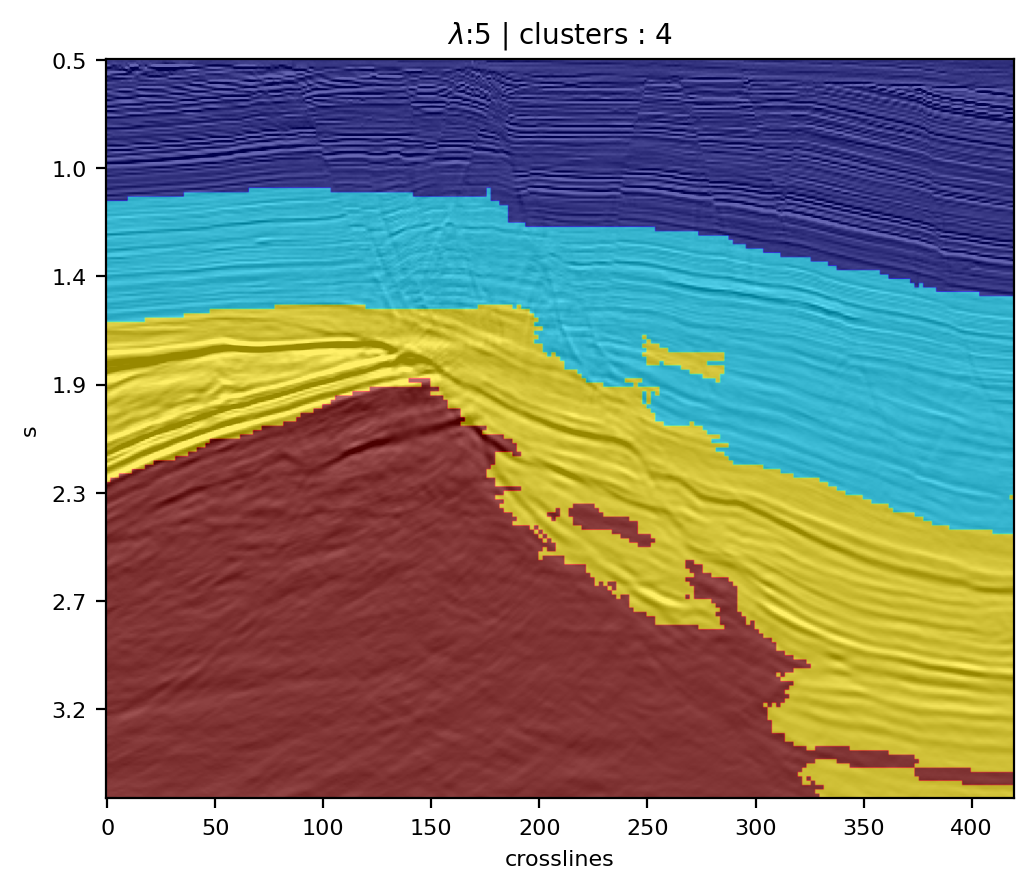

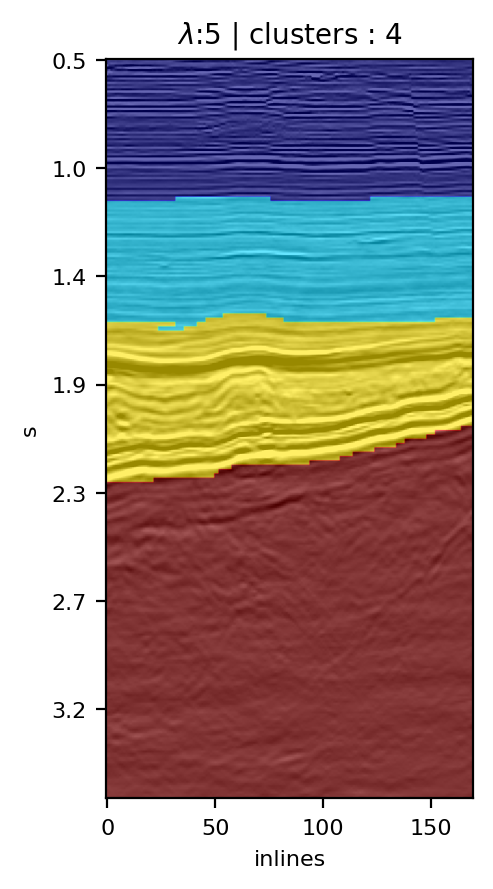

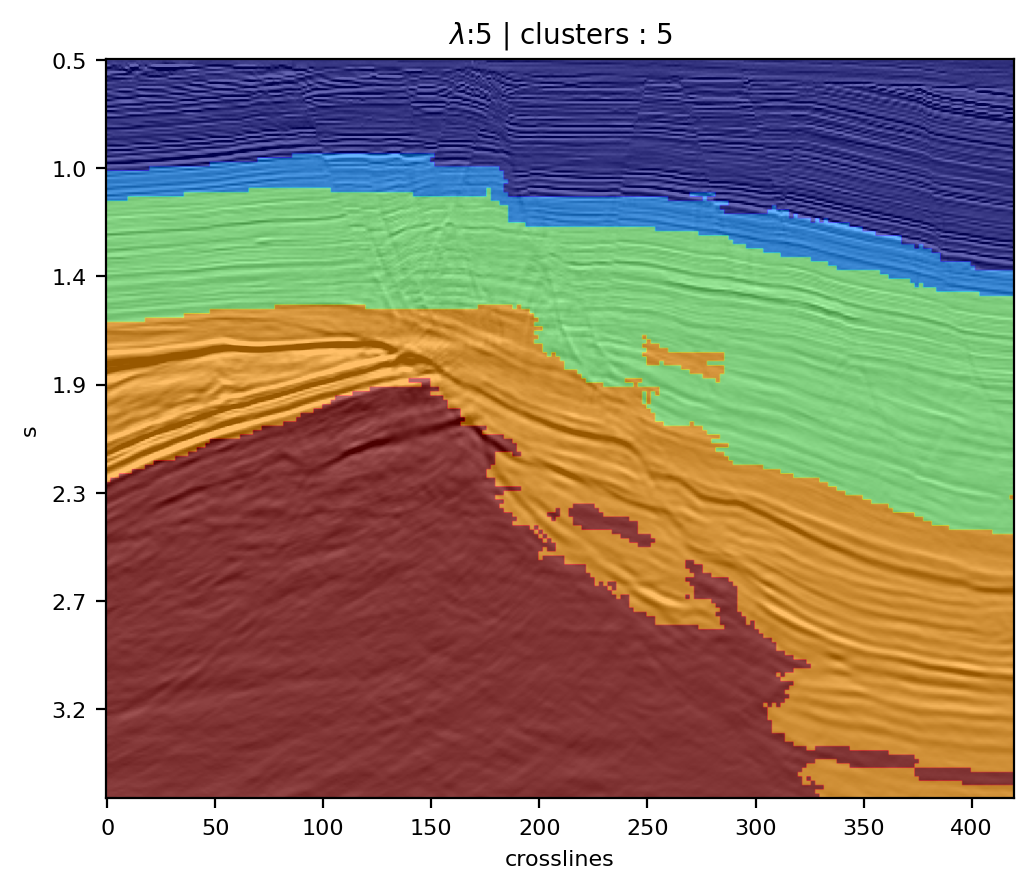

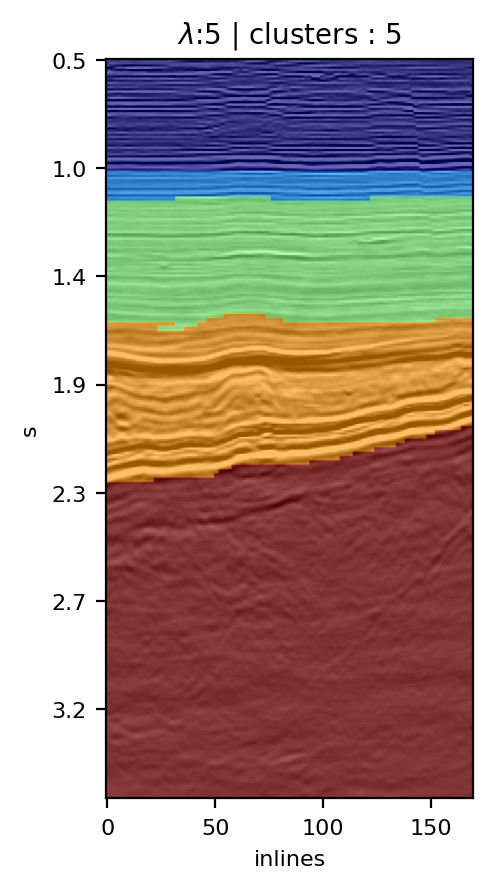

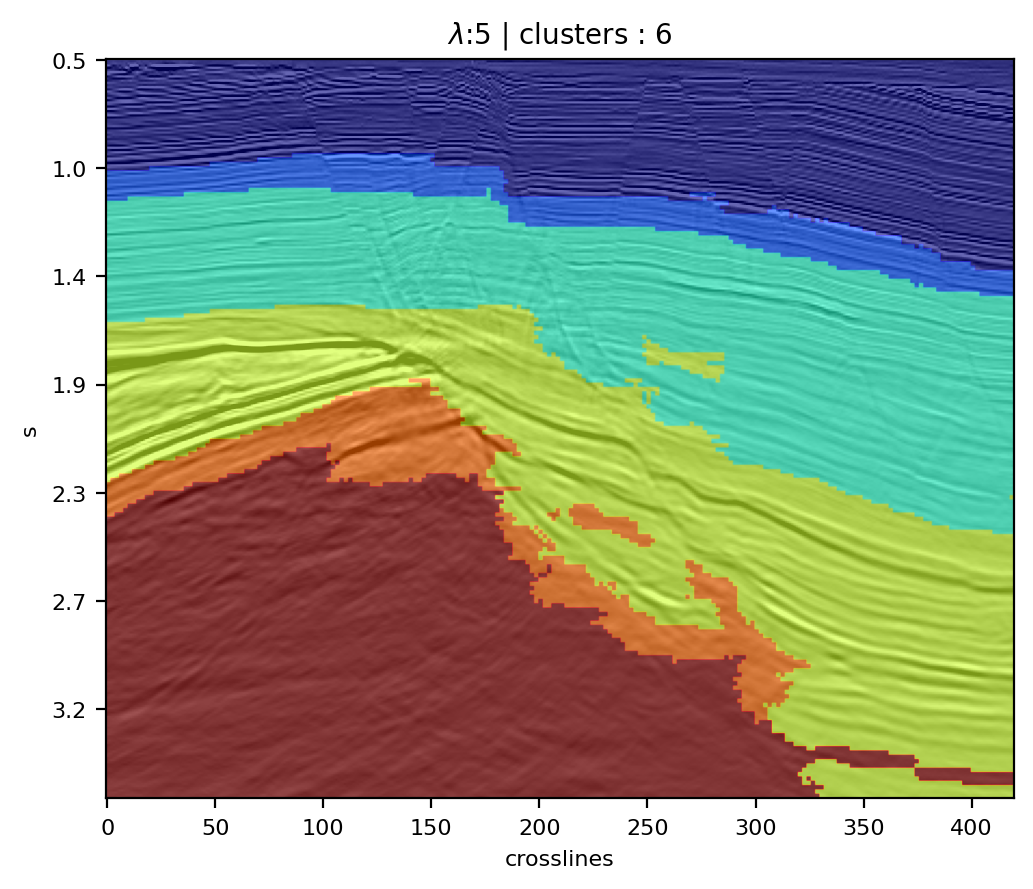

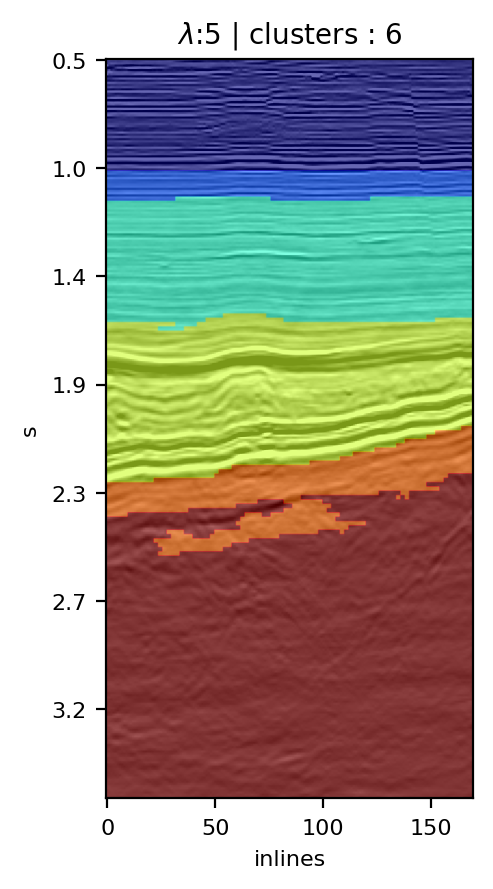

In [39]:
import numpy as np
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from itertools import product
from joblib import Memory
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
if 'memory' not in os.listdir():
  os.mkdir(f'memory')
memory = Memory(location='memory', verbose=0)

inlines = np.unique(indices[:,1])
xlines = np.unique(indices[:,2])

print("inlines:" , inlines)
print("xlines:" , xlines)

dims = [len(np.unique(indices[:,i])) for i in range(3)]

ils = np.linspace(0,dims[1] - 1, 5).astype(int)
xls = np.linspace(0,dims[2] - 1, 15).astype(int)

n_x, n_y, n_z = dims

# Create a mask for the two slices
mask = np.zeros(dims, dtype=bool)
for il in ils:
    mask[:, il, :] = True
for xl in xls:
    mask[:, :, xl] = True


# Create a list of 3D indices for each voxel in the mask
coords = np.array(list(product(range(n_x), range(n_y), range(n_z))))
mask_indices = coords[mask.flatten()]

# Generate enhanced connectivity graph
connectivity = kneighbors_graph(mask_indices, n_neighbors = 6 , include_self=True)

n_clusters = [4,5,6]
w = 5
for clust in n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=clust, connectivity=connectivity, memory=memory)
    position = phase_volume[mask,:]
    texture = feature_volume[mask,:]

    position = (position - position.mean()) / position.std()
    texture = (texture - texture.mean()) / texture.std()


    title = r'$\lambda$:'+f'{w} | clusters : {clust}'

    combined = np.concatenate( (texture, position ) , axis=1)

    scaler = StandardScaler()
    feats = scaler.fit_transform(combined)
    feats[...,-1] *= w


    labels = clusterer.fit_predict(feats)

    # Create an empty volume for the labels
    label_volume = np.full(dims, -1)  # or use another placeholder value

    # Map the cluster labels back to their original positions
    label_volume[mask] = labels

    centroid = calculate_centroids(label_volume)
    label_volume = relabel_array(label_volume, centroid)

    label_volume_zoom = ndimage.zoom(label_volume, zoom = ZOOM_FACTOR, order = 0)

    hw = [(dat_crop.shape[i] - label_volume_zoom.shape[i]) // 2 for i in range(3)]
    background = dat_crop[hw[0]:-hw[0], hw[1]:-hw[1], hw[2]:-hw[2]]

    fig, ax = plt.subplots(1, 1, dpi = 200)
    ax.set_title(title, fontsize=10)

    ax.imshow(background[:, 0, :], **eq, cmap='gray')
    ax.imshow(label_volume_zoom[:, 0, : ], alpha=0.6, cmap='jet')

    time_axis = np.linspace(130,dat.shape[0],len(ax.get_yticks()[1:-1]))
    time_axis = np.round( time_axis * 0.004, 1)

    ax.set_yticks(ax.get_yticks()[1:-1], time_axis)
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.set_ylabel('s',fontsize=8)
    ax.set_xlabel('crosslines',fontsize=8)
    plt.show()


    fig, ax = plt.subplots(1, 1, dpi = 200)
    ax.set_title(title, fontsize=10)

    ax.imshow(background[:, :, 0], **eq, cmap='gray')
    ax.imshow(label_volume_zoom[:, :, 0], alpha=0.6, cmap='jet')

    ax.set_yticks(ax.get_yticks()[1:-1],time_axis)
    ax.tick_params(axis='both', which='major', labelsize=8)

    ax.set_ylabel('s',fontsize=8)
    ax.set_xlabel('inlines',fontsize=8)



